In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import numpy as np
import torch

from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl

import glob
%run icnn.py

# Purely input convex neural networks

## Test 1: is it in fact convex?

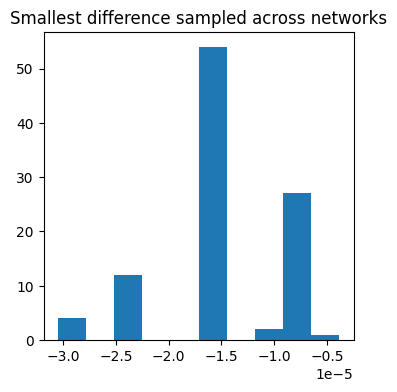

In [3]:
minDiffs = []
for i in range(100):
    model = BasicICNN()
    xtest = 10*torch.randn(1000, 2, 2)
    alphas = torch.rand(1000)

    diffs = (alphas[:,None]*model.forward(xtest[:,:,0]) + (1-alphas[:,None])*model.forward(xtest[:,:,1]) 
                - model.forward( alphas[:,None] * xtest[:,:,0] + (1-alphas[:,None]) * xtest[:,:,1] ) )
    minDiffs.append(diffs.min().detach())

figsize(4,4)
plt.title('Smallest difference sampled across networks')
plt.hist(minDiffs);


Here we see that there are some very slight deviations from convexity caused by the outputs being too close to linear. I'm not worried about this level of deviation

## Test 2: Learning

Training a simple 3 layer network, with early stopping, on a simple objective produces pretty good results. The network is able to be trained.

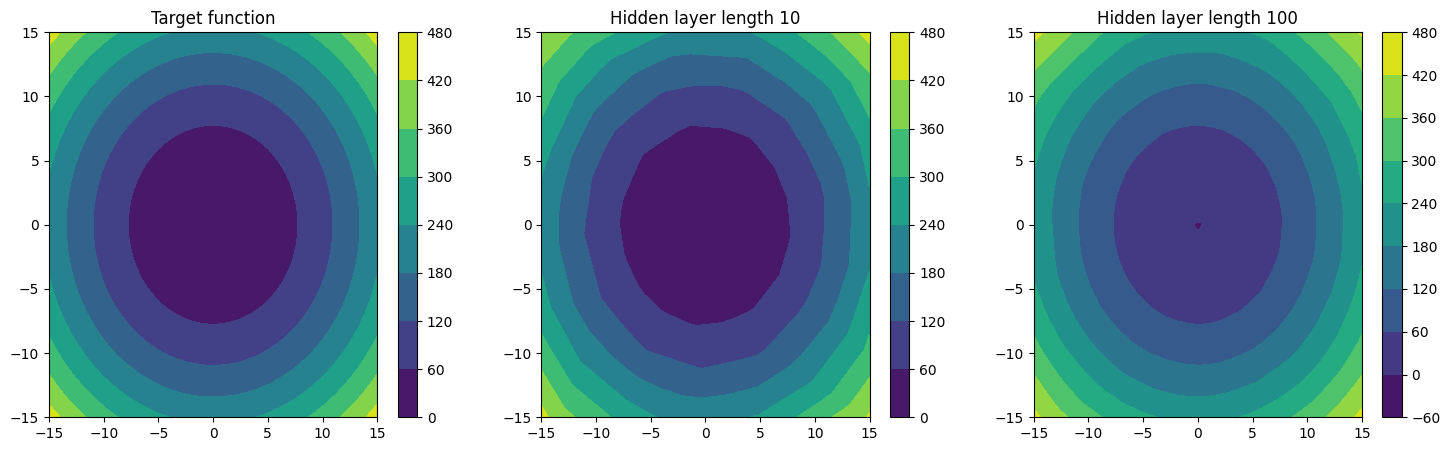

In [24]:
# 10 dim model
smallCheckpoint = glob.glob('lightning_logs/simpleQuadratic/*')[0]
smallModel = BasicICNN.load_from_checkpoint(smallCheckpoint)

# 100 dim model
largeCheckpoint = glob.glob('lightning_logs/simpleQuadratic_largeLatentDim/*')[1]
largeModel = BasicICNN.load_from_checkpoint(largeCheckpoint)


p1 = np.linspace(-15, 15, 1001)
p2 = np.linspace(-15, 15, 1001)

P1, P2 = np.meshgrid(p1, p2)

figsize(18,5)
plt.subplots(1,3)
plt.subplot(1,3,1)
plt.contourf(P1, P2, P1**2 + P2**2)
plt.xlim([-15,15])
plt.ylim([-15,15])
plt.title('Target function')
plt.colorbar()

plt.subplot(1,3,2)
testx = torch.tensor( np.stack([P1, P2]).reshape( 2, 1001*1001).T, dtype=torch.float32)
testy = smallModel.forward(testx)
plt.contourf( P1, P2, testy.detach().numpy().reshape(1001, 1001))
plt.title('Hidden layer length 10')
plt.colorbar()

plt.subplot(1,3,3)
testx = torch.tensor( np.stack([P1, P2]).reshape( 2, 1001*1001).T, dtype=torch.float32)
testy = largeModel.forward(testx)
plt.contourf( P1, P2, testy.detach().numpy().reshape(1001, 1001))
plt.title('Hidden layer length 100')
plt.colorbar()

# Partially input convex neural networks

Here we allow for a second group of inputs that the function is not convex in

## Convexity

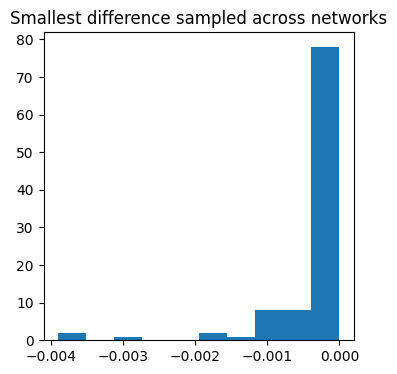

In [7]:
minDiffs = []
for i in range(100):
    model = PartialICNN()
    ytest = 10*torch.randn(1000, 2, 2)
    xtest = 10*torch.randn(1000, 2)
    alphas = torch.rand(1000)

    diffs = (alphas[:,None]*model.forward(xtest, ytest[:,:,0]) + (1-alphas[:,None])*model.forward(xtest, ytest[:,:,1]) 
                - model.forward(xtest, alphas[:,None] * ytest[:,:,0] + (1-alphas[:,None]) * ytest[:,:,1] ) )
    minDiffs.append(diffs.min().detach())

figsize(4,4)
plt.title('Smallest difference sampled across networks')
plt.hist(minDiffs);

Again, there are some small, albeit slightly bigger this time, deviations from convexity.

## learning 1:

Initial model: batch normalization along the input stream

### Easy task first: x independent objective


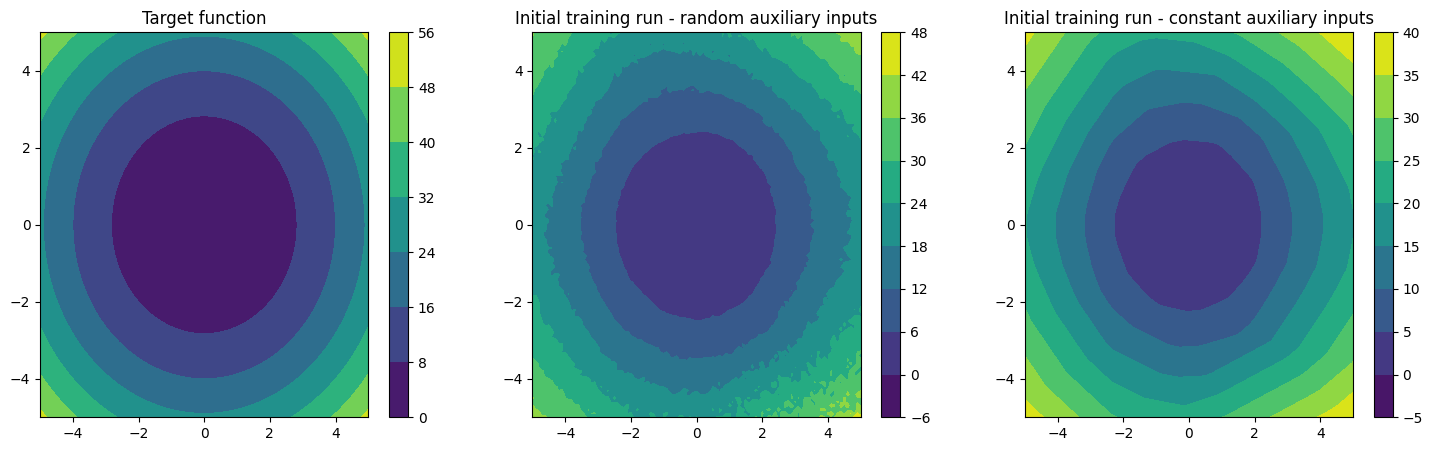

In [50]:
partialModel = PartialICNN.load_from_checkpoint('lightning_logs/partialTest_indep/epoch=1429-step=183040.ckpt')
partialModel = partialModel.eval()

targetFun = lambda x, y: (y[:,0]**2 + y[:,1]**2)[:,None]

p1 = np.linspace(-5, 5, 101)
p2 = np.linspace(-5, 5, 101)

P1, P2 = np.meshgrid(p1, p2)

testy = torch.tensor( np.stack([P1, P2]).reshape( 2, 101*101).T, dtype=torch.float32)
testx = torch.randn(101*101, 2) 

figsize(18,5)
plt.subplots(1,3)
plt.subplot(1,3,1)
plt.contourf(P1, P2, targetFun(testx, testy).detach().reshape( 101, 101) )
plt.title('Target function')
plt.colorbar()

plt.subplot(1,3,2)
plt.contourf( P1, P2, partialModel.forward(testx, testy).detach().numpy().reshape(101, 101))
plt.title('Initial training run - random auxiliary inputs')
plt.colorbar()


plt.subplot(1,3,3)
testx = torch.zeros(101*101, 2)
plt.contourf( P1, P2, partialModel.forward(testx, testy).detach().numpy().reshape(101, 101))
plt.title('Initial training run - constant auxiliary inputs')
plt.colorbar()

Ok. When the output is constant in the the non-convex input, the network does learn fairly well. Of course, it could be better, but this may be a reflection of a simple lack of training examples. This input space is generally high dimensional.

## Objetive function that varies with input $x$

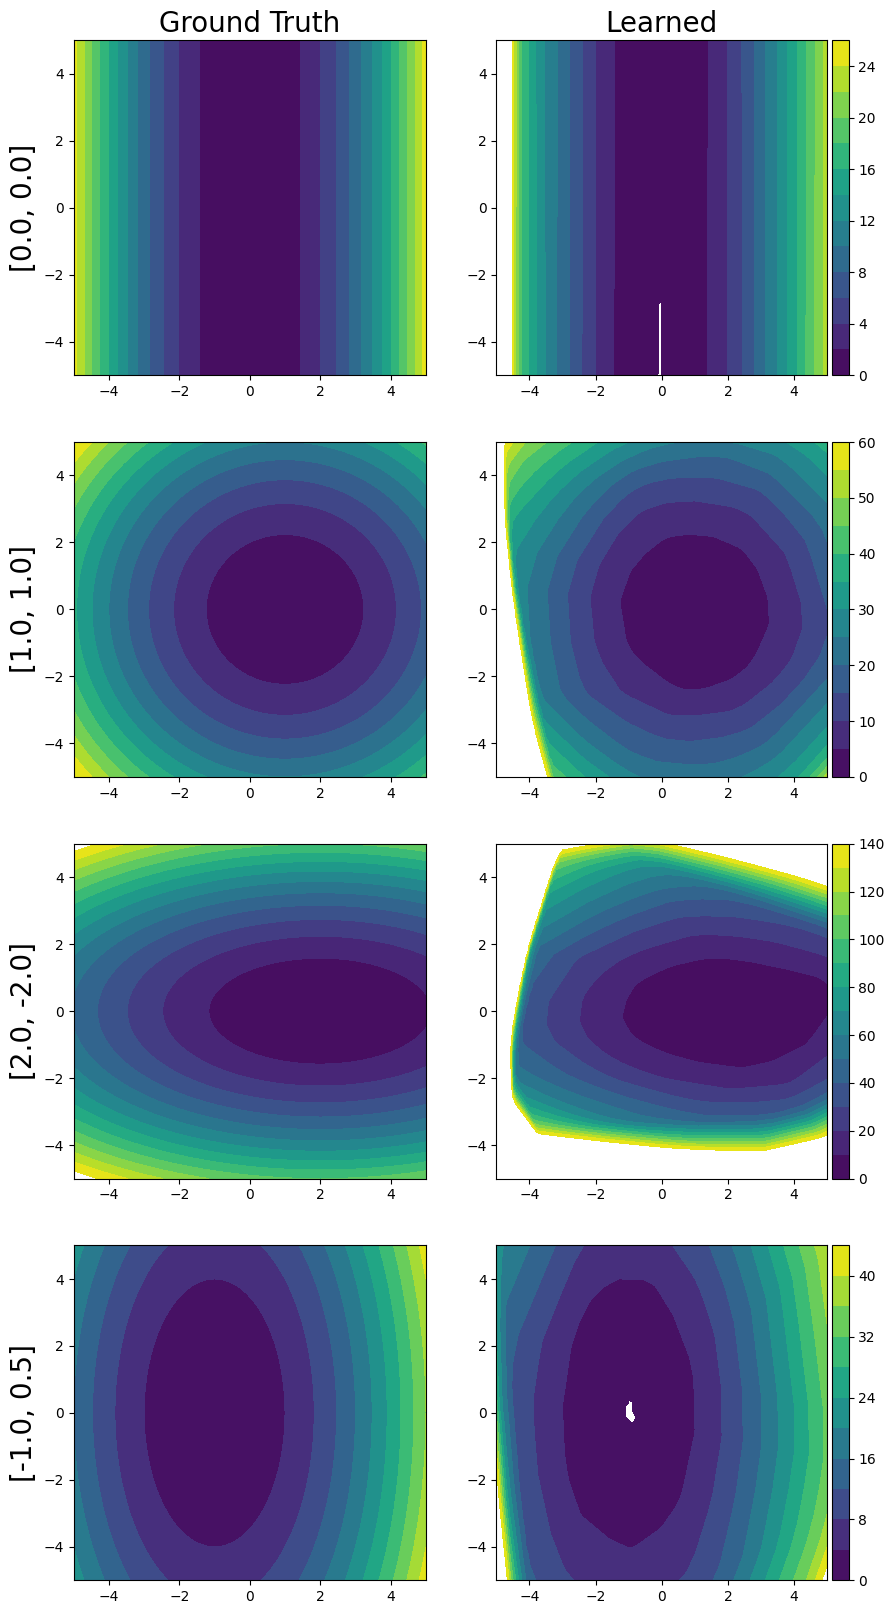

In [147]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

partialModel = PartialICNN.load_from_checkpoint('lightning_logs/batchNorm_conv/epoch=890-step=228096.ckpt')
partialModel = partialModel.eval()

targetFunction = lambda x, y: ((y[:,0] - x[:,0])**2 + x[:,1]**2*y[:,1]**2)[:,None]

p1 = np.linspace(-5, 5, 101)
p2 = np.linspace(-5, 5, 101)

P1, P2 = np.meshgrid(p1, p2)

testy = torch.tensor( np.stack([P1, P2]).reshape( 2, 101*101).T, dtype=torch.float32)


xvalues = [ torch.tensor([0.,0.]), torch.tensor([1., 1.]), torch.tensor([2., -2.]), torch.tensor( [-1., 0.5]) ]
colorbarLevels = [range(0,28,2), range(0,65,5), range(0,150,10), range(0,48,4)]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for ind, ax in enumerate(axes):
    testx = xvalues[ind].repeat(101*101, 1)
    colorlevels = colorbarLevels[ind]

    if ind == 0:
        ax[0].set_title('Ground Truth', fontsize=20)
        ax[1].set_title('Learned', fontsize=20)
    
    ax[0].set_ylabel( xvalues[ ind].tolist(), fontsize=20 )
    ax[0].contourf(P1, P2, targetFunction(testx, testy).detach().reshape( 101, 101), levels=colorlevels )
    im = ax[1].contourf(P1, P2, partialModel.forward(testx, testy).detach().numpy().reshape(101, 101), levels=colorlevels )

    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    




#### Overall, this is pretty good. 

It's learning well, albeit with a tendency to grow too large very quickly at the boundaries. This is not terribly surprising, because the training distribution is normal around zero with a standard deviation of 2, so regions of $x$ and $y$ values that are further from zero are not as well sampled. 

There is also some jaggedness to the learned solutions, they could probably benefit from more hidden layers.

Empirically, batch normalization _is_ necessary, models without it don't show learning at the level of learning curves.


# Learning through the optimization

In [5]:
%run learnedOptimization.py
model = GradientDescentOptimizer.load_from_checkpoint('lightning_logs/learningThroughOptimizer2/epoch=309-step=79360.ckpt')

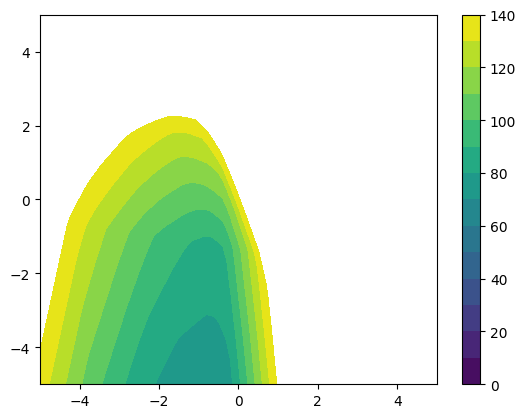

In [26]:
p1 = np.linspace(-5, 5, 101)
p2 = np.linspace(-5, 5, 101)

P1, P2 = np.meshgrid(p1, p2)

testy = torch.tensor( np.stack([P1, P2]).reshape( 2, 101*101).T, dtype=torch.float32)
testx = torch.zeros(101*101, 2) - 1

plt.contourf(P1, P2, model.partialConvexNN(testx, testy).detach().reshape( 101, 101), levels=range(0,150,10) )
plt.colorbar()

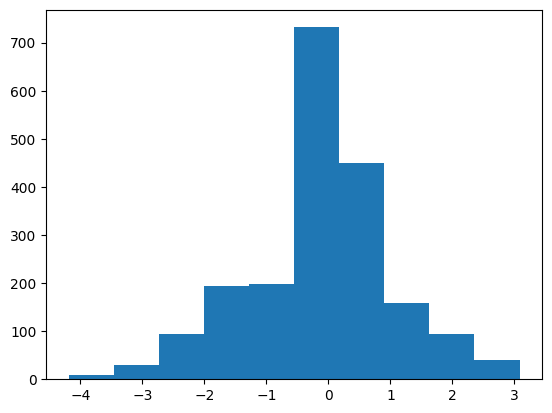

In [32]:
xs= torch.randn(1000,2)
plt.hist( (model.forward(xs) - xs).reshape(-1).detach() );

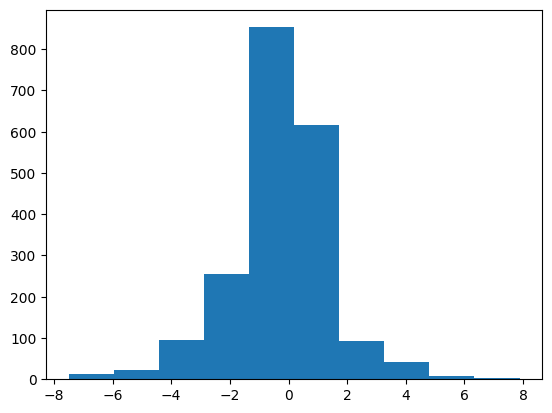

In [37]:
model.hparams.optimizationSteps = 100
model.hparams.stepSize=0.01

plt.hist( (model.forward(xs) - xs).reshape(-1).detach() );

Just not there yet.